In [1]:
import pennylane as qml

from pennylane import numpy as np
from pennylane.templates import RandomLayers

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt

import time

from itertools import product
from itertools import combinations_with_replacement

In [2]:
# JAX

import jax
import jax.numpy as jnp

from jax.config import config

config.update("jax_enable_x64", True)


# GPUs

import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ", ".join(map(str, range(6, 16)))

In [3]:
jax.devices()

[GpuDevice(id=0, process_index=0),
 GpuDevice(id=1, process_index=0),
 GpuDevice(id=2, process_index=0),
 GpuDevice(id=3, process_index=0),
 GpuDevice(id=4, process_index=0),
 GpuDevice(id=5, process_index=0),
 GpuDevice(id=6, process_index=0),
 GpuDevice(id=7, process_index=0),
 GpuDevice(id=8, process_index=0),
 GpuDevice(id=9, process_index=0)]

In [4]:
### Parameters part

In [5]:
# 1) Pennylane

qml_device_types = [ 
    "default.qubit.jax", 
    "lightning.qubit",
    "lightning.gpu",  
    "default.qubit",
]

JAX_COMPATIBLE_DEVICES = ["default.qubit.jax"]

# 2) Image

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28


# 3) Filters

MIN_FILTER_WIDTH = 1
MAX_FILTER_WIDTH = 5

MIN_FILTER_HEIGHT = 1
MAX_FILTER_HEIGHT = 1

MIN_FILTERS_COUNT = 10
MAX_FILTERS_COUNT = 10

MIN_RANDOM_LAYERS_COUNT = 1
MAX_RANDOM_LAYERS_COUNT = 1

UNIQUE_FILTER_REPETITIONS = False

# 4) Strides

MIN_STRIDE_WIDTH = 1
MAX_STRIDE_WIDTH = 1

MIN_STRIDE_HEIGHT = 1
MAX_STRIDE_HEIGHT = 1


# 5) Seeds

np.random.seed(0)
tf.random.set_seed(0)

In [6]:
def get_combinations(widths, heights):    
   
    sizes = []
    
    for width in widths:
        for height in heights:
            
            size = (width, height)
            reversed_size = (height, width)
                           
            if reversed_size in sizes:
                continue
                
            sizes.append(size)    
   
    sorted_sizes = tuple(sorted(sizes))    

    return sorted_sizes

In [7]:
### Secondary parameter calculation

# 1) Pennylane

# -


# 2) Image

image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)


# 3) Filters

max_filter_width = min(MAX_FILTER_WIDTH + 1, IMAGE_WIDTH + 1)
max_filter_height = min(MAX_FILTER_HEIGHT + 1, IMAGE_HEIGHT + 1)

filter_widths = list(range(MIN_FILTER_WIDTH, max_filter_width))
filter_heights = list(range(MIN_FILTER_HEIGHT, max_filter_height))

filter_sizes = get_combinations(filter_widths, filter_heights)

filter_counts = range(MIN_FILTERS_COUNT, MAX_FILTERS_COUNT + 1)

filter_combinations = list(product(filter_sizes, filter_counts))

random_layer_counts = list(range(MIN_RANDOM_LAYERS_COUNT, 
                                 MAX_RANDOM_LAYERS_COUNT + 1))


# 4) Strides

stride_widths = range(MIN_STRIDE_WIDTH, MAX_STRIDE_WIDTH + 1)
stride_heights = range(MIN_STRIDE_HEIGHT, MAX_STRIDE_HEIGHT + 1)

strides = get_combinations(stride_widths, stride_heights)


# 5) Seeds

# -

In [8]:
### Data preparation part

In [9]:
def load_one_MNIST_image():

    # Load MNIST dataset

    mnist_dataset = keras.datasets.mnist
    train_data, test_data = mnist_dataset.load_data()

    train_images, train_labels = train_data
    test_images, test_labels = test_data

    # Normalize pixels

    train_images = train_images / 255
    test_images = test_images / 255

    # Add extra dimension for convolution channels

    train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
    test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

    one_image = train_images[0]
    
    return one_image

In [10]:
def parse_image(image_size, filter_size, stride_size, filters_count):
    
    image_width, image_height = image_size    
    filter_width, filter_height = filter_size
    stride_width, stride_height = stride_size
        
    filter_surface = filter_width * filter_height
    
    # Repetition counts
    
    if stride_width >= filter_width:
        
        horizontal_filter_repetitions = image_width // stride_width        
        horizontal_filter_repetitions += (image_width % stride_width) >= filter_width  

    else:        
       
        horizontal_filter_repetitions = (image_width - filter_width + 1) // stride_width  

        
    if stride_height >= filter_height:
        
        vertical_filter_repetitions = image_height // stride_height        
        vertical_filter_repetitions += (image_height % stride_height) >= filter_height
        
    else:
 
        vertical_filter_repetitions = (image_height - filter_height + 1) // stride_height
    
    
    filter_repetitions = horizontal_filter_repetitions * vertical_filter_repetitions        

    complexity = (2 ** filter_surface
                  * filters_count
                  * filter_repetitions) 

    result = {"filter_width": filter_width, 
              "filter_height": filter_height,
              "filter_surface": filter_surface,
              "filters_count": filters_count,

              "stride_width": stride_width,
              "stride_height": stride_height,                      
              
              "horizontal_filter_repetitions": horizontal_filter_repetitions,
              "vertical_filter_repetitions": vertical_filter_repetitions,
              "filter_repetitions": filter_repetitions,              

              "complexity": complexity}
    
    return result

In [11]:
def get_pixel_values(image, experiment):
     
    filter_width = experiment['filter_width']
    filter_height = experiment['filter_height']  
    filters_count = experiment['filters_count']

    stride_width = experiment['stride_width']
    stride_height = experiment['stride_height']
    
    feature_width = horizontal_filter_repetitions = experiment['horizontal_filter_repetitions']    
    feature_height = vertical_filter_repetitions = experiment['vertical_filter_repetitions']
    
    channels_count = qubits_count = filter_surface = experiment['filter_surface']
   
    # Fetch pixels
    
    pixel_values_dict = dict()
    
    for feature_x in range(horizontal_filter_repetitions):
        
        image_corner_x = feature_x * stride_width
        
        for feature_y in range(vertical_filter_repetitions):
            
            image_corner_y = feature_y * stride_height
                
            image_fragment = image[image_corner_y : image_corner_y + filter_height,
                                   image_corner_x : image_corner_x + filter_width] 
            
            pixel_values_dict[(feature_x, feature_y)] = image_fragment.flatten()            
    
    pixel_values_array = jnp.array(list(pixel_values_dict.values()))
    
    return pixel_values_array

In [12]:
### Quantum part

In [13]:
def filter_circuit(pixel_values, random_layer_parameters):
       
    qubits = list(range(len(pixel_values)))

    for qubit, pixel_value in enumerate(pixel_values):     

        theta = jnp.pi * pixel_value        
        qml.RY(theta, wires=qubit)        
    
    RandomLayers(random_layer_parameters, wires=qubits)

    measurement_result = [qml.expval(qml.PauliZ(qubit)) for qubit in qubits]
    
    return measurement_result

In [14]:
def quanvolve_vmap(pixel_values_array, random_layer_parameters, bound_filter_circuit):

    # VMap
    
    vmapped_circuit = jax.vmap(bound_filter_circuit, in_axes=(0, None))
    
    vmapped_output = vmapped_circuit(pixel_values_array,
                                     random_layer_parameters)
    
    # print("pixel_values_array:", pixel_values_array)    
    # print("vmapped_output:", vmapped_output) 
    
    # print("pixel_values_array shape:", pixel_values_array.shape)
    # print("vmapped_output shape:", vmapped_output.shape)   
    
    return vmapped_output

In [15]:
def quanvolve_no_vmap(pixel_values_array, random_layer_parameters, bound_filter_circuit):        
  
    output = []
    
    for pixel_values in pixel_values_array:
        
        result = bound_filter_circuit(pixel_values,
                                      random_layer_parameters)
        
        output.append(result)
        
    output_array = jnp.array(output)
    
    # print("pixel_values_array:", pixel_values_array)    
    # print("output_array:", output_array) 
    
    # print("pixel_values_array.shape:", pixel_values_array.shape)
    # print("output_array.shape:", output_array.shape)   
    
    return output_array

In [16]:
### Experiments part

In [17]:
def prepare_experiments():

    experiment_list = []

    for filter_size, filters_count in filter_combinations:

        for stride_size in strides:

            for random_layers_count in random_layer_counts:

                experiment = parse_image(image_size, filter_size, stride_size, filters_count)
                
                if UNIQUE_FILTER_REPETITIONS:
                
                    skip_experiment = False

                    for existing_experiment in experiment_list:

                        if existing_experiment['filter_repetitions'] == experiment['filter_repetitions']:

                            skip_experiment = True
                            break

                    if skip_experiment:
                        continue

                experiment['random_layers_count'] = random_layers_count

                experiment_list.append(experiment)    

    sorted_experiments = sorted(experiment_list, 
                                key=lambda experiment: experiment['complexity'])

    sorted_updated_experiments = []

    for device_type in qml_device_types:
         for experiment in sorted_experiments:

            if device_type in JAX_COMPATIBLE_DEVICES:
                interface = "jax"
                paralellize = True
                vectorize = True

            else:
                interface = "autograd"
                paralellize = False
                vectorize = False
                
            updated_experiment = {**experiment, 
                                  'device_type': device_type,
                                  'interface': interface,
                                  'paralellize': paralellize,
                                  'vectorize': vectorize}
                
            sorted_updated_experiments.append(updated_experiment)

    experiments = dict(enumerate(sorted_updated_experiments))
    
    print(f"Experiments count: {len(experiments)}")
    
    return experiments

In [18]:
def run_experiment(experiment_id, experiment):   
   
    start_time = time.time()
    
    # Ininitialize
    
    filter_width = experiment['filter_width']
    filter_height = experiment['filter_height']  
    filters_count = experiment['filters_count']

    stride_width = experiment['stride_width']
    stride_height = experiment['stride_height']
    
    feature_width = experiment['horizontal_filter_repetitions']    
    feature_height = experiment['vertical_filter_repetitions']    
   
    random_layers_count = experiment['random_layers_count']
    
    channels_count = qubits_count = filter_surface = experiment['filter_surface']
   
    device_type = experiment['device_type']
    interface = experiment['interface']
    
    paralellize_flag = experiment['paralellize']
    vectorize_flag = experiment['vectorize']
    
    
    # Bind filter circuit
    
    qml_device = qml.device(device_type, wires=qubits_count)
    
    bound_filter_circuit = qml.QNode(filter_circuit, qml_device, interface=interface)
    
    
    # Input parameters
    
    pixel_values_array = get_pixel_values(image, experiment)    
    
    random_layer_parameters_array =  np.random.uniform(high=2 * jnp.pi,
                                                       size=(filters_count,
                                                             random_layers_count,
                                                             channels_count))
    
    # Vectorize
    
    quanvolve = quanvolve_vmap if vectorize_flag else quanvolve_no_vmap
    
    
    # Paralellize
    
    if paralellize_flag:
   
        pmapped_quanvolve = jax.pmap(quanvolve,
                                     axis_name='filters',
                                     static_broadcasted_argnums=[2],
                                     in_axes=(None, 0, None))    

        filter_outputs = pmapped_quanvolve(pixel_values_array, 
                                           random_layer_parameters_array, 
                                           bound_filter_circuit)
       
    else:
        
        filter_outputs_list = []
        
        for random_layer_parameters in random_layer_parameters_array:
            
            filter_outputs_list.append(quanvolve(pixel_values_array,
                                                 random_layer_parameters,
                                                 bound_filter_circuit))
            
        filter_outputs = np.array(filter_outputs_list)
        
        
    feature_outputs = filter_outputs.reshape(filters_count, 
                                             feature_width, 
                                             -1, 
                                             channels_count)        
    
    # Printouts
    
    # print("pixel_values_array:", pixel_values_array)
    # print("random_layer_parameters_array:", random_layer_parameters_array)
    # print("filter_outputs:", filter_outputs)
    # print("feature_outputs:", feature_outputs)

    # print("pixel_values_array.shape:", pixel_values_array.shape)
    # print("random_layer_parameters_array.shape:", random_layer_parameters_array.shape)     
    # print("filter_outputs.shape:", filter_outputs.shape)  
    # print("feature_outputs.shape:", feature_outputs.shape)
    
      
    # Time
    
    execution_time = time.time() - start_time
    
    return execution_time

In [19]:
def run_experiments(experiments):

    experiments_count = len(experiments)

    for experiment_id, experiment in experiments.items():

        if 'execution_time' not in experiment:

            interface = experiment['interface']
            vectorize = experiment['vectorize']
            paralellize = experiment['paralellize']
            device_type = experiment['device_type']
            filters_count = experiment['filters_count']
            filter_surface = experiment['filter_surface']
            filter_repetitions = experiment['filter_repetitions']
            random_layers_count = experiment['random_layers_count']

            print(f"Experiment: {experiment_id + 1}/{experiments_count}")
            # display(experiment)
            print(f"Device: {device_type}")
            # print(f"Interface: {interface}")
            # print(f"Vectorize: {vectorize}")
            # print(f"Paralellize: {paralellize}")
            # print(f"Filters count: {filters_count}")
            print(f"Qubits per filter: {filter_surface}")
            print(f"Filter repetitions: {filter_repetitions}")
            # print(f"Random layers count: {random_layers_count}")


            execution_time = run_experiment(experiment_id, experiment)

            experiments[experiment_id]['execution_time'] = execution_time

            print(f"Execution time: {execution_time:.2f} seconds\n")

In [20]:
### Run

In [21]:
image = load_one_MNIST_image()

In [22]:
experiments = prepare_experiments()

Experiments count: 20


In [23]:
run_experiments(experiments)

Experiment: 1/20
Device: default.qubit.jax
Qubits per filter: 1
Filter repetitions: 784
Execution time: 9.47 seconds

Experiment: 2/20
Device: default.qubit.jax
Qubits per filter: 2
Filter repetitions: 756
Execution time: 0.34 seconds

Experiment: 3/20
Device: default.qubit.jax
Qubits per filter: 3
Filter repetitions: 728
Execution time: 0.45 seconds

Experiment: 4/20
Device: default.qubit.jax
Qubits per filter: 4
Filter repetitions: 700
Execution time: 0.56 seconds

Experiment: 5/20
Device: default.qubit.jax
Qubits per filter: 5
Filter repetitions: 672
Execution time: 0.70 seconds

Experiment: 6/20
Device: lightning.qubit
Qubits per filter: 1
Filter repetitions: 784


/opt/conda/lib/python3.8/site-packages/pennylane/math/multi_dispatch.py:65: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Execution time: 10.20 seconds

Experiment: 7/20
Device: lightning.qubit
Qubits per filter: 2
Filter repetitions: 756
Execution time: 13.04 seconds

Experiment: 8/20
Device: lightning.qubit
Qubits per filter: 3
Filter repetitions: 728
Execution time: 16.67 seconds

Experiment: 9/20
Device: lightning.qubit
Qubits per filter: 4
Filter repetitions: 700
Execution time: 18.60 seconds

Experiment: 10/20
Device: lightning.qubit
Qubits per filter: 5
Filter repetitions: 672
Execution time: 21.18 seconds

Experiment: 11/20
Device: lightning.gpu
Qubits per filter: 1
Filter repetitions: 784
Execution time: 11.51 seconds

Experiment: 12/20
Device: lightning.gpu
Qubits per filter: 2
Filter repetitions: 756
Execution time: 13.93 seconds

Experiment: 13/20
Device: lightning.gpu
Qubits per filter: 3
Filter repetitions: 728
Execution time: 17.46 seconds

Experiment: 14/20
Device: lightning.gpu
Qubits per filter: 4
Filter repetitions: 700
Execution time: 20.29 seconds

Experiment: 15/20
Device: lightning.

In [24]:
### Visualization part

In [25]:
# Aggregate execution times

from collections import defaultdict


execution_times = defaultdict(lambda: defaultdict(list))

for experiment_id, experiment in experiments.items():
    
    if 'execution_time' not in experiment:
        continue
    
    device_type = experiment['device_type']
    qubit_count = experiment['filter_surface']
    execution_time = experiment['execution_time']
    filter_repetitions = experiment['filter_repetitions']
    
    execution_times[device_type]['qubit_count'].append(qubit_count)
    execution_times[device_type]['execution_time'].append(execution_time)
    execution_times[device_type]['filter_repetitions'].append(filter_repetitions)

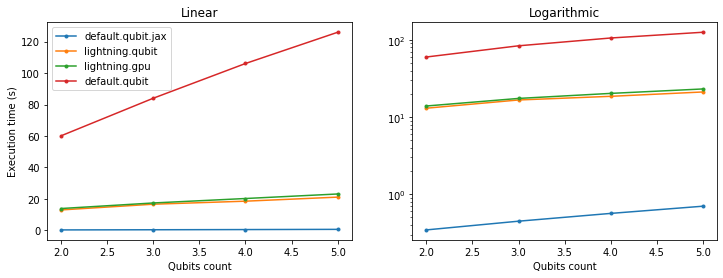

In [26]:
# Plot per qubit

figure, (linear, logarithmic) = plt.subplots(1, 2, figsize=(12, 4))

for device_type in execution_times:
    
    qubit_count = execution_times[device_type]['qubit_count']
    execution_time = execution_times[device_type]['execution_time']

    linear.plot(qubit_count[1:], 
                execution_time[1:], 
                '.-', label=device_type)
    
    logarithmic.plot(qubit_count[1:], 
                     execution_time[1:], 
                     '.-', label=device_type)
    
linear.set_title("Linear")
linear.set_ylabel("Execution time (s)")
linear.set_xlabel("Qubits count")
linear.legend()

logarithmic.set_title("Logarithmic")
logarithmic.set_xlabel("Qubits count")
logarithmic.set_yscale("log")

plt.show()

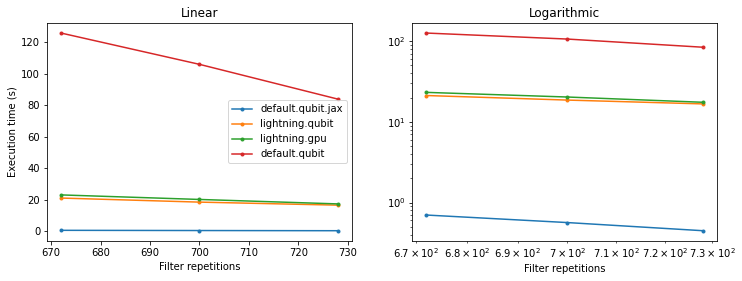

In [28]:
# Plot per filter repetitions

figure, (linear, logarithmic) = plt.subplots(1, 2, figsize=(12, 4))

for device_type in execution_times:
    
    filter_repetitions = execution_times[device_type]['filter_repetitions']
    execution_time = execution_times[device_type]['execution_time']
    
    # print("filter_repetitions:", filter_repetitions)
    # print("execution_time:", execution_time)

    linear.plot(filter_repetitions[2:], 
                execution_time[2:], 
                '.-', label=device_type)
    
    logarithmic.plot(filter_repetitions[2:], 
                     execution_time[2:], 
                     '.-', label=device_type)
    
linear.set_title("Linear")
linear.set_ylabel("Execution time (s)")
linear.set_xlabel("Filter repetitions")
# linear.set_yscale("log")
linear.legend()

logarithmic.set_title("Logarithmic")
logarithmic.set_xlabel("Filter repetitions")
logarithmic.set_xscale("log")
logarithmic.set_yscale("log")

plt.show()